# About me:



## Profile
**Name** : BVSG Suraj

**Batch** : 7

**Project** : Implement [Facial Expression Recognition](https://github.com/zlpure/Facial-Expression-Recognition) using winograd convolutions and write a tutorial on the same.

## Current Status

Implementing seperable convolutions.

## Logs
* 21/6 : used kernel_size=5 with data augmentation and class weights. Amazing improvement in performance. (IN PROGRESS)
* 20/6 : Found few valuable observations during the hyperparameter tuning. (DONE)
* 19/6 : The validation accuracy did not improve much over epochs while using 'class_weights'. 
* 18/6 : Ditching Winograd Implementation. Going with Seperable Conv. (DONE)
* 16/6 : Implementing winograd convolutions for 2D data (ABORTTED)
* 14/6 : Performing EDA and some data pre-processing. (DONE)
* 13/6 : Setting up Jupyter Notebook. (DONE)
* 12/6 : Understanding Winograg Convolution. (DONE)
* 10/6 : Starting literature survey. (DONE)

# Preliminary Setup


In [0]:
#Installing required libraries
!pip install -q keras
#!pip install -q --upgrade git+git://github.com/fchollet/keras.git
!pip install -q pathlib

In [2]:
#Linking drive to colab to store datasets
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up gnupg-agent (2.1.15-1ubuntu8.1) ...
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up gnupg (2.1.15-1ubuntu8.1) 

In [3]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library. Though the link asks you to verify twice, you don't have to!
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/EIP/Facial_Expression_Recognition/

Files in Drive:
datalab  fer2013  fer2013.tar.gz


In [5]:
!ls 

datalab  drive


In [6]:
#Unpack datasets and copy back to drive. Just once at the beginning.
#!tar -xvf drive/EIP/Facial_Expression_Recognition/fer2013.tar.gz
!cp -r fer2013 drive/EIP/Facial_Expression_Recognition

# Run this only when starting a new session. Syncing files in drive to pwd.
!cp -a drive/EIP/Facial_Expression_Recognition/*.hdf5 .
#!ls

cp: cannot stat 'fer2013': No such file or directory
cp: cannot stat 'drive/EIP/Facial_Expression_Recognition/*.hdf5': No such file or directory


# Environment specific Setup

In [0]:
#Framework related libraries
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam

##---------------------------------------------##

#For loading models
from pathlib import Path
from keras.models import load_model

##---------------------------------------------##

##Data preprocessing

#for class balance
from sklearn.utils import class_weight

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##---------------------------------------------##

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
#tf.python.control_flow_ops = tf
from keras import backend as k

##---------------------------------------------##

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

##---------------------------------------------##

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
#Data handling libraries
import numpy as np
import pandas as spd

##---------------------------------------------##

#Image handling libraries
import matplotlib.pyplot as plt

##---------------------------------------------##

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis



In [0]:
#Given data set is in csv format after unzipping.

file = 'drive/EIP/Facial_Expression_Recognition/fer2013/fer2013.csv'
df = spd.read_csv(file)

In [0]:
#Assign separate data frames to training, cross-validation and test data

#Training set
tr_set = df.loc[df['Usage'] == 'Training']
tr = tr_set.loc[:,'pixels']
tr_labels = tr_set.loc[:,'emotion']

#Cross-validation set
cv_set = df.loc[df['Usage'] == 'PublicTest']
cv = cv_set.loc[:,'pixels']
cv_labels = cv_set.loc[:,'emotion']

#Test set
te_set = df.loc[df['Usage'] == 'PrivateTest']
te = te_set.loc[:,'pixels']
te_labels = te_set.loc[:,'emotion']

Lets randomly sample 5 images of each emotion from training dtaset

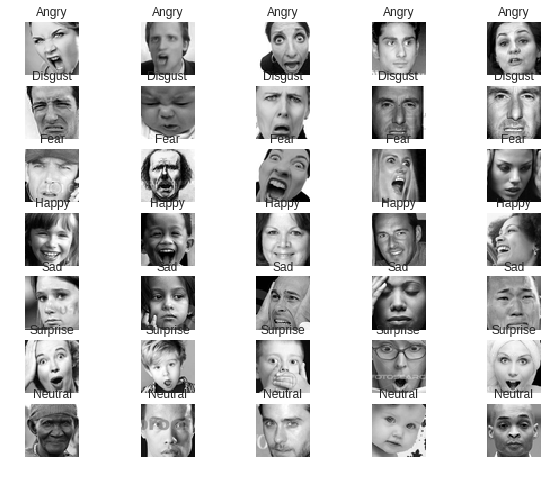

In [8]:
tr_set_emotions_label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

#size of each class will be stored in this array
t=np.zeros(np.size(tr_set_emotions_label)) 

#No. of images to sample from each class
sample_size=5

#Display those images
for k,e in enumerate(tr_set_emotions_label):
  this_emotion_set = df.loc[(df['Usage'] == 'Training') & (df['emotion'] == k)]
  t[k] = this_emotion_set.size
  x=this_emotion_set.sample(n=sample_size).loc[:,'pixels']
  for i,j in enumerate(x):
    plt.subplot(t.size, sample_size,(sample_size*k)+i+1)
    y = j.split(' ')
    x = np.array(y).reshape(48,48)
    plt.axis('off')
    plt.grid('off')
    plt.imshow(x.astype('uint8'))
    plt.title(e)

## Inferences


1.   The data provided is flattened/unrolled. To display them, we have to roll or reshape the vectors.
2.   This dataset consists of faces of various expressions of all kinds of age, race and sex. That means the data is well generalized. 
3.   Faces in the images seemed to be centered. So, face detection and extraction can be skipped.
4.   Images are in grey scale. That means fewer parameters.
5.  Given the classes 'Surprise' and 'Happy', there might be high chance of misclassification. This is due to their high spatial corelation.

Let's explore data distribution among various classes

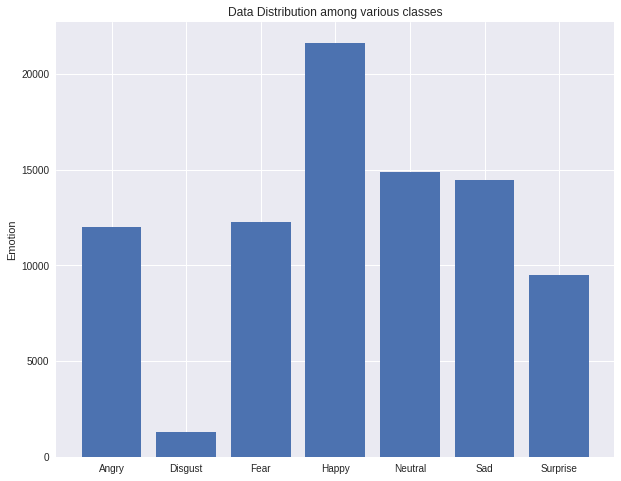

In [9]:
#Plotting no. of training examples vs their class
plt.bar(tr_set_emotions_label, t)
plt.ylabel('No. of training examples')
plt.ylabel('Emotion')
plt.title('Data Distribution among various classes')

plt.show()  

* It can be observed that the class 'Disgust' has very less number of training data. 

* And there is a high possibility of the model to predict 'Happy' if the training data isn't normalized.

* This problem can be solved in various ways:

  1.** Assigning weightage** for each class using Keras 'class_weight'. This is preferred.
  
  2.** Data augmentation** - Since the variation among the no. of training examples accross the classes is very high, using augmentation might not be a good idea. If we do that, there will be a rich variation in 'Happy' class and less variations in 'disgust' class and training over this data would be redundant. But applying Augmentation on all of the classes is a good idea.
  
  3.** Removing data** from other classes. Loss of data is not encouraged usually. 

  4.** Using GANs** : New training data can be created from the respective class's distribution. This is an option too.


**NOTE : The labels on the x-axis are not in order of the labels 0-7**

# Data Preprocessing


## Rolling the data

In [10]:
#train data
tr_img = []
tr_l = np.zeros((np.size(tr),np.size(t)))
#print(tr_labels)
for p,i in enumerate(tr):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    tr_img.append(y)
    tr_l[p,tr_labels[p]]=1
tr_img = np.array(tr_img)
print(tr_img.shape)

(28709, 48, 48, 1)


In [11]:
#cv data
cv_img = []
cv_l = np.zeros((np.size(cv),np.size(t)))
for p,i in enumerate(cv):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    cv_img.append(y)
    cv_l[p,cv_labels[np.size(tr)+p]] = 1
print(cv_l)
cv_img = np.array(cv_img)
print(cv_img.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(3589, 48, 48, 1)


In [12]:
#test data
te_img = []
te_l = np.zeros((np.size(te),np.size(t)))
for p,i in enumerate(te):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    te_img.append(y)
    te_l[p,te_labels[np.size(tr) + np.size(cv) + p]]=1
print(te_l)
te_img = np.array(te_img)
print(te_img.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(3589, 48, 48, 1)


## Assigning weights to classes

In [0]:
#Finding the weightage to be given to each class
class_weights_array = np.round(np.max(t)/t)

class_weight = dict(zip(np.arange(np.size(t)), class_weights_array))

#print(class_weight)

# Data Augmentation

In [14]:
print('Using real-time data augmentation.')

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True) 

datagen.fit(tr_img)
data_aug_x = datagen.flow(tr_img, tr_l, batch_size=64)

Using real-time data augmentation.


# Acrhitecture

## Model

In [32]:
model = Sequential()

f = 32
model.add(SeparableConv2D(f,(5,1),activation='relu', input_shape=(48,48,1)))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

##

f=64
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.1))

##

f=96
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.1))

##
'''
f=256
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.25))
'''
##

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_25 (Separab (None, 44, 48, 32)        69        
_________________________________________________________________
separable_conv2d_26 (Separab (None, 44, 44, 32)        1216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
separable_conv2d_27 (Separab (None, 40, 44, 32)        1216      
_________________________________________________________________
separable_conv2d_28 (Separab (None, 40, 40, 32)        1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
separable_conv2d_29 (Separab (None, 35, 39, 64)        2272      
__________

## Compile and run

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint
from keras.callbacks import ModelCheckpoint
filepath= "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

## Epoch 1-10

In [20]:
epoch = 0
model.fit_generator(data_aug_x, 
                    epochs=10,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

Epoch 1/10
449/449 [==============================] - 74s 165ms/step - loss: 3.1269 - acc: 0.1440 - val_loss: 2.0257 - val_acc: 0.1301

Epoch 00001: val_acc improved from -inf to 0.13012, saving model to weights-improvement-01-0.13.hdf5
Epoch 2/10
178/449 [==========>...................] - ETA: 39s - loss: 3.0965 - acc: 0.1721

449/449 [==============================] - 71s 159ms/step - loss: 3.0287 - acc: 0.1890 - val_loss: 2.2046 - val_acc: 0.1413

Epoch 00002: val_acc improved from 0.13012 to 0.14126, saving model to weights-improvement-02-0.14.hdf5
Epoch 3/10
243/449 [===============>..............] - ETA: 30s - loss: 2.9241 - acc: 0.2190

449/449 [==============================] - 71s 159ms/step - loss: 2.8985 - acc: 0.2299 - val_loss: 1.8912 - val_acc: 0.2226

Epoch 00003: val_acc improved from 0.14126 to 0.22262, saving model to weights-improvement-03-0.22.hdf5
Epoch 4/10
259/449 [================>.............] - ETA: 27s - loss: 2.8198 - acc: 0.2564

449/449 [==============================] - 71s 159ms/step - loss: 2.7969 - acc: 0.2745 - val_loss: 1.7857 - val_acc: 0.3012

Epoch 00004: val_acc improved from 0.22262 to 0.30120, saving model to weights-improvement-04-0.30.hdf5
Epoch 5/10
263/449 [================>.............] - ETA: 27s - loss: 2.7191 - acc: 0.3055

449/449 [==============================] - 72s 159ms/step - loss: 2.7144 - acc: 0.3094 - val_loss: 2.1325 - val_acc: 0.2368

Epoch 00005: val_acc did not improve from 0.30120
Epoch 6/10
318/449 [====================>.........] - ETA: 19s - loss: 2.6328 - acc: 0.3386

449/449 [==============================] - 71s 159ms/step - loss: 2.6306 - acc: 0.3418 - val_loss: 1.8115 - val_acc: 0.3079

Epoch 00006: val_acc improved from 0.30120 to 0.30789, saving model to weights-improvement-06-0.31.hdf5
Epoch 7/10
278/449 [=================>............] - ETA: 25s - loss: 2.5837 - acc: 0.3630

449/449 [==============================] - 71s 159ms/step - loss: 2.5781 - acc: 0.3620 - val_loss: 2.0816 - val_acc: 0.2622

Epoch 00007: val_acc did not improve from 0.30789
Epoch 8/10
323/449 [====================>.........] - ETA: 18s - loss: 2.5236 - acc: 0.3730

449/449 [==============================] - 71s 159ms/step - loss: 2.5244 - acc: 0.3750 - val_loss: 1.5936 - val_acc: 0.4032

Epoch 00008: val_acc improved from 0.30789 to 0.40318, saving model to weights-improvement-08-0.40.hdf5
Epoch 9/10
279/449 [=================>............] - ETA: 24s - loss: 2.5004 - acc: 0.3848

449/449 [==============================] - 71s 159ms/step - loss: 2.4758 - acc: 0.3879 - val_loss: 2.0948 - val_acc: 0.2558

Epoch 00009: val_acc did not improve from 0.40318
Epoch 10/10
322/449 [====================>.........] - ETA: 18s - loss: 2.4606 - acc: 0.3952

449/449 [==============================] - 71s 159ms/step - loss: 2.4400 - acc: 0.3997 - val_loss: 1.4250 - val_acc: 0.4542

Epoch 00010: val_acc improved from 0.40318 to 0.45417, saving model to weights-improvement-10-0.45.hdf5


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/

## Epoch 11-30

In [22]:
model.load_weights('weights-improvement-10-0.45.hdf5')
epoch = 10
model.fit_generator(data_aug_x, 
                    epochs=30,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

Epoch 11/30
449/449 [==============================] - 71s 159ms/step - loss: 2.4167 - acc: 0.4095 - val_loss: 1.5185 - val_acc: 0.4277

Epoch 00011: val_acc did not improve from 0.45417
Epoch 12/30
209/449 [============>.................] - ETA: 35s - loss: 2.3691 - acc: 0.4218

449/449 [==============================] - 71s 159ms/step - loss: 2.3683 - acc: 0.4209 - val_loss: 1.7392 - val_acc: 0.3514

Epoch 00012: val_acc did not improve from 0.45417
Epoch 13/30
301/449 [===================>..........] - ETA: 21s - loss: 2.3478 - acc: 0.4205

449/449 [==============================] - 71s 159ms/step - loss: 2.3374 - acc: 0.4244 - val_loss: 1.3916 - val_acc: 0.4634

Epoch 00013: val_acc improved from 0.45417 to 0.46336, saving model to weights-improvement-13-0.46.hdf5
Epoch 14/30
273/449 [=================>............] - ETA: 25s - loss: 2.3110 - acc: 0.4323

449/449 [==============================] - 72s 159ms/step - loss: 2.3084 - acc: 0.4322 - val_loss: 1.9373 - val_acc: 0.3332

Epoch 00014: val_acc did not improve from 0.46336
Epoch 15/30
320/449 [====================>.........] - ETA: 18s - loss: 2.2972 - acc: 0.4332

449/449 [==============================] - 71s 159ms/step - loss: 2.2829 - acc: 0.4348 - val_loss: 1.4977 - val_acc: 0.4338

Epoch 00015: val_acc did not improve from 0.46336
Epoch 16/30
334/449 [=====================>........] - ETA: 16s - loss: 2.2717 - acc: 0.4425

449/449 [==============================] - 72s 159ms/step - loss: 2.2713 - acc: 0.4420 - val_loss: 1.4101 - val_acc: 0.4592

Epoch 00016: val_acc did not improve from 0.46336
Epoch 17/30
338/449 [=====================>........] - ETA: 16s - loss: 2.2276 - acc: 0.4460

449/449 [==============================] - 72s 159ms/step - loss: 2.2463 - acc: 0.4442 - val_loss: 1.4255 - val_acc: 0.4558

Epoch 00017: val_acc did not improve from 0.46336
Epoch 18/30
340/449 [=====================>........] - ETA: 15s - loss: 2.2128 - acc: 0.4516

449/449 [==============================] - 71s 158ms/step - loss: 2.2227 - acc: 0.4543 - val_loss: 1.7752 - val_acc: 0.3550

Epoch 00018: val_acc did not improve from 0.46336
Epoch 19/30
340/449 [=====================>........] - ETA: 15s - loss: 2.2133 - acc: 0.4495

449/449 [==============================] - 71s 159ms/step - loss: 2.2029 - acc: 0.4528 - val_loss: 1.4324 - val_acc: 0.4667

Epoch 00019: val_acc improved from 0.46336 to 0.46670, saving model to weights-improvement-19-0.47.hdf5
Epoch 20/30
283/449 [=================>............] - ETA: 24s - loss: 2.1654 - acc: 0.4588

449/449 [==============================] - 71s 159ms/step - loss: 2.1867 - acc: 0.4579 - val_loss: 1.6747 - val_acc: 0.3753

Epoch 00020: val_acc did not improve from 0.46670
Epoch 21/30
323/449 [====================>.........] - ETA: 18s - loss: 2.1910 - acc: 0.4596

449/449 [==============================] - 71s 159ms/step - loss: 2.1837 - acc: 0.4583 - val_loss: 1.4790 - val_acc: 0.4542

Epoch 00021: val_acc did not improve from 0.46670
Epoch 22/30
335/449 [=====================>........] - ETA: 16s - loss: 2.1560 - acc: 0.4688

449/449 [==============================] - 71s 158ms/step - loss: 2.1599 - acc: 0.4662 - val_loss: 1.3570 - val_acc: 0.4921

Epoch 00022: val_acc improved from 0.46670 to 0.49206, saving model to weights-improvement-22-0.49.hdf5
Epoch 23/30
282/449 [=================>............] - ETA: 24s - loss: 2.1150 - acc: 0.4697

449/449 [==============================] - 71s 158ms/step - loss: 2.1443 - acc: 0.4693 - val_loss: 1.4749 - val_acc: 0.4494

Epoch 00023: val_acc did not improve from 0.49206
Epoch 24/30
323/449 [====================>.........] - ETA: 18s - loss: 2.1267 - acc: 0.4722

449/449 [==============================] - 71s 158ms/step - loss: 2.1419 - acc: 0.4668 - val_loss: 1.5000 - val_acc: 0.4458

Epoch 00024: val_acc did not improve from 0.49206
Epoch 25/30
335/449 [=====================>........] - ETA: 16s - loss: 2.1354 - acc: 0.4740

449/449 [==============================] - 71s 159ms/step - loss: 2.1167 - acc: 0.4762 - val_loss: 1.4105 - val_acc: 0.4812

Epoch 00025: val_acc did not improve from 0.49206
Epoch 26/30
339/449 [=====================>........] - ETA: 16s - loss: 2.0982 - acc: 0.4767

449/449 [==============================] - 71s 159ms/step - loss: 2.1018 - acc: 0.4774 - val_loss: 1.5501 - val_acc: 0.4235

Epoch 00026: val_acc did not improve from 0.49206
Epoch 27/30
340/449 [=====================>........] - ETA: 15s - loss: 2.0813 - acc: 0.4829

449/449 [==============================] - 71s 159ms/step - loss: 2.1029 - acc: 0.4768 - val_loss: 1.3770 - val_acc: 0.4859

Epoch 00027: val_acc did not improve from 0.49206
Epoch 28/30
340/449 [=====================>........] - ETA: 15s - loss: 2.0891 - acc: 0.4818

449/449 [==============================] - 71s 158ms/step - loss: 2.0827 - acc: 0.4827 - val_loss: 1.2947 - val_acc: 0.5177

Epoch 00028: val_acc improved from 0.49206 to 0.51769, saving model to weights-improvement-28-0.52.hdf5
Epoch 29/30
283/449 [=================>............] - ETA: 24s - loss: 2.0904 - acc: 0.4863

449/449 [==============================] - 71s 159ms/step - loss: 2.0859 - acc: 0.4853 - val_loss: 1.4169 - val_acc: 0.4661

Epoch 00029: val_acc did not improve from 0.51769
Epoch 30/30
324/449 [====================>.........] - ETA: 18s - loss: 2.0573 - acc: 0.4944

449/449 [==============================] - 71s 158ms/step - loss: 2.0682 - acc: 0.4902 - val_loss: 1.4793 - val_acc: 0.4687

Epoch 00030: val_acc did not improve from 0.51769


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/

## Epoch 31-50

In [27]:
model.load_weights('weights-improvement-28-0.52.hdf5')
epoch = 30
model.fit_generator(data_aug_x, 
                    epochs=50,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 31/50
449/449 [==============================] - 71s 159ms/step - loss: 2.0718 - acc: 0.4845 - val_loss: 1.3477 - val_acc: 0.5026

Epoch 00031: val_acc did not improve from 0.51769
Epoch 32/50
210/449 [=============>................] - ETA: 35s - loss: 2.0268 - acc: 0.4920

449/449 [==============================] - 71s 159ms/step - loss: 2.0495 - acc: 0.4919 - val_loss: 1.3710 - val_acc: 0.4809

Epoch 00032: val_acc did not improve from 0.51769
Epoch 33/50
301/449 [===================>..........] - ETA: 21s - loss: 2.0449 - acc: 0.4916

449/449 [==============================] - 71s 159ms/step - loss: 2.0529 - acc: 0.4891 - val_loss: 1.2915 - val_acc: 0.5205

Epoch 00033: val_acc improved from 0.51769 to 0.52048, saving model to weights-improvement-33-0.52.hdf5
Epoch 34/50
273/449 [=================>............] - ETA: 25s - loss: 2.0427 - acc: 0.4881

449/449 [==============================] - 71s 158ms/step - loss: 2.0399 - acc: 0.4933 - val_loss: 1.2639 - val_acc: 0.5300

Epoch 00034: val_acc improved from 0.52048 to 0.52995, saving model to weights-improvement-34-0.53.hdf5
Epoch 35/50
266/449 [================>.............] - ETA: 26s - loss: 2.0385 - acc: 0.4932

449/449 [==============================] - 71s 159ms/step - loss: 2.0344 - acc: 0.4959 - val_loss: 1.3655 - val_acc: 0.4976

Epoch 00035: val_acc did not improve from 0.52995
Epoch 36/50
318/449 [====================>.........] - ETA: 19s - loss: 2.0228 - acc: 0.4972

449/449 [==============================] - 71s 159ms/step - loss: 2.0249 - acc: 0.4939 - val_loss: 1.4328 - val_acc: 0.4678

Epoch 00036: val_acc did not improve from 0.52995
Epoch 37/50
334/449 [=====================>........] - ETA: 16s - loss: 2.0121 - acc: 0.4987

449/449 [==============================] - 71s 159ms/step - loss: 2.0160 - acc: 0.4982 - val_loss: 1.3354 - val_acc: 0.5104

Epoch 00037: val_acc did not improve from 0.52995
Epoch 38/50
338/449 [=====================>........] - ETA: 16s - loss: 1.9995 - acc: 0.4978

449/449 [==============================] - 71s 158ms/step - loss: 2.0115 - acc: 0.4955 - val_loss: 1.3511 - val_acc: 0.4862

Epoch 00038: val_acc did not improve from 0.52995
Epoch 39/50
339/449 [=====================>........] - ETA: 16s - loss: 1.9777 - acc: 0.5042

449/449 [==============================] - 71s 158ms/step - loss: 1.9837 - acc: 0.5024 - val_loss: 1.5074 - val_acc: 0.4455

Epoch 00039: val_acc did not improve from 0.52995
Epoch 40/50
340/449 [=====================>........] - ETA: 15s - loss: 1.9936 - acc: 0.5015

449/449 [==============================] - 71s 158ms/step - loss: 1.9904 - acc: 0.5030 - val_loss: 1.2955 - val_acc: 0.5235

Epoch 00040: val_acc did not improve from 0.52995
Epoch 41/50
340/449 [=====================>........] - ETA: 15s - loss: 1.9637 - acc: 0.5092

449/449 [==============================] - 71s 159ms/step - loss: 1.9775 - acc: 0.5064 - val_loss: 1.3186 - val_acc: 0.5065

Epoch 00041: val_acc did not improve from 0.52995
Epoch 42/50
340/449 [=====================>........] - ETA: 15s - loss: 2.0070 - acc: 0.4980

449/449 [==============================] - 71s 158ms/step - loss: 1.9957 - acc: 0.4994 - val_loss: 1.2453 - val_acc: 0.5369

Epoch 00042: val_acc improved from 0.52995 to 0.53692, saving model to weights-improvement-42-0.54.hdf5
Epoch 43/50
283/449 [=================>............] - ETA: 24s - loss: 1.9617 - acc: 0.5079

449/449 [==============================] - 71s 159ms/step - loss: 1.9608 - acc: 0.5088 - val_loss: 1.2937 - val_acc: 0.5249

Epoch 00043: val_acc did not improve from 0.53692
Epoch 44/50
323/449 [====================>.........] - ETA: 18s - loss: 1.9772 - acc: 0.5065

449/449 [==============================] - 71s 159ms/step - loss: 1.9738 - acc: 0.5073 - val_loss: 1.4044 - val_acc: 0.4932

Epoch 00044: val_acc did not improve from 0.53692
Epoch 45/50
335/449 [=====================>........] - ETA: 16s - loss: 1.9420 - acc: 0.5133

449/449 [==============================] - 71s 158ms/step - loss: 1.9504 - acc: 0.5142 - val_loss: 1.5344 - val_acc: 0.4391

Epoch 00045: val_acc did not improve from 0.53692
Epoch 46/50
339/449 [=====================>........] - ETA: 16s - loss: 1.9539 - acc: 0.5059

449/449 [==============================] - 71s 158ms/step - loss: 1.9429 - acc: 0.5104 - val_loss: 1.3246 - val_acc: 0.5130

Epoch 00046: val_acc did not improve from 0.53692
Epoch 47/50
340/449 [=====================>........] - ETA: 15s - loss: 1.9367 - acc: 0.5100

449/449 [==============================] - 71s 157ms/step - loss: 1.9351 - acc: 0.5112 - val_loss: 1.2440 - val_acc: 0.5277

Epoch 00047: val_acc did not improve from 0.53692
Epoch 48/50
341/449 [=====================>........] - ETA: 15s - loss: 1.9260 - acc: 0.5144

449/449 [==============================] - 71s 158ms/step - loss: 1.9411 - acc: 0.5144 - val_loss: 1.3842 - val_acc: 0.4962

Epoch 00048: val_acc did not improve from 0.53692
Epoch 49/50
341/449 [=====================>........] - ETA: 15s - loss: 1.9491 - acc: 0.5131

449/449 [==============================] - 71s 158ms/step - loss: 1.9341 - acc: 0.5150 - val_loss: 1.3464 - val_acc: 0.4943

Epoch 00049: val_acc did not improve from 0.53692
Epoch 50/50
341/449 [=====================>........] - ETA: 15s - loss: 1.9385 - acc: 0.5137

449/449 [==============================] - 71s 158ms/step - loss: 1.9332 - acc: 0.5144 - val_loss: 1.2613 - val_acc: 0.5255

Epoch 00050: val_acc did not improve from 0.53692


## Epoch 51-70

In [28]:
model.load_weights('weights-improvement-42-0.54.hdf5')
epoch = 50
model.fit_generator(data_aug_x, 
                    epochs=70,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 51/70
449/449 [==============================] - 71s 159ms/step - loss: 1.9916 - acc: 0.5028 - val_loss: 1.3708 - val_acc: 0.4937

Epoch 00051: val_acc did not improve from 0.53692
Epoch 52/70
209/449 [============>.................] - ETA: 35s - loss: 1.9463 - acc: 0.5131

449/449 [==============================] - 71s 159ms/step - loss: 1.9500 - acc: 0.5138 - val_loss: 1.2894 - val_acc: 0.5166

Epoch 00052: val_acc did not improve from 0.53692
Epoch 53/70
301/449 [===================>..........] - ETA: 21s - loss: 1.9454 - acc: 0.5148

449/449 [==============================] - 71s 158ms/step - loss: 1.9627 - acc: 0.5123 - val_loss: 1.3689 - val_acc: 0.4870

Epoch 00053: val_acc did not improve from 0.53692
Epoch 54/70
329/449 [====================>.........] - ETA: 17s - loss: 1.9517 - acc: 0.5091

449/449 [==============================] - 71s 158ms/step - loss: 1.9499 - acc: 0.5100 - val_loss: 1.3849 - val_acc: 0.4893

Epoch 00054: val_acc did not improve from 0.53692
Epoch 55/70
337/449 [=====================>........] - ETA: 16s - loss: 1.9412 - acc: 0.5087

449/449 [==============================] - 71s 159ms/step - loss: 1.9372 - acc: 0.5097 - val_loss: 1.2609 - val_acc: 0.5313

Epoch 00055: val_acc did not improve from 0.53692
Epoch 56/70
339/449 [=====================>........] - ETA: 16s - loss: 1.9170 - acc: 0.5197

449/449 [==============================] - 71s 158ms/step - loss: 1.9308 - acc: 0.5179 - val_loss: 1.3811 - val_acc: 0.4884

Epoch 00056: val_acc did not improve from 0.53692
Epoch 57/70
340/449 [=====================>........] - ETA: 16s - loss: 1.9455 - acc: 0.5104

449/449 [==============================] - 71s 159ms/step - loss: 1.9354 - acc: 0.5122 - val_loss: 1.2661 - val_acc: 0.5180

Epoch 00057: val_acc did not improve from 0.53692
Epoch 58/70
340/449 [=====================>........] - ETA: 15s - loss: 1.9148 - acc: 0.5178

449/449 [==============================] - 71s 158ms/step - loss: 1.9242 - acc: 0.5171 - val_loss: 1.3287 - val_acc: 0.4999

Epoch 00058: val_acc did not improve from 0.53692
Epoch 59/70
340/449 [=====================>........] - ETA: 15s - loss: 1.9120 - acc: 0.5106

449/449 [==============================] - 71s 159ms/step - loss: 1.9074 - acc: 0.5153 - val_loss: 1.4096 - val_acc: 0.4606

Epoch 00059: val_acc did not improve from 0.53692
Epoch 60/70
340/449 [=====================>........] - ETA: 15s - loss: 1.9434 - acc: 0.5084

449/449 [==============================] - 71s 158ms/step - loss: 1.9325 - acc: 0.5135 - val_loss: 1.2565 - val_acc: 0.5336

Epoch 00060: val_acc did not improve from 0.53692
Epoch 61/70
340/449 [=====================>........] - ETA: 16s - loss: 1.9126 - acc: 0.5150

449/449 [==============================] - 71s 159ms/step - loss: 1.9083 - acc: 0.5172 - val_loss: 1.4257 - val_acc: 0.4859

Epoch 00061: val_acc did not improve from 0.53692
Epoch 62/70
341/449 [=====================>........] - ETA: 15s - loss: 1.9015 - acc: 0.5230

449/449 [==============================] - 71s 159ms/step - loss: 1.9076 - acc: 0.5206 - val_loss: 1.2854 - val_acc: 0.5294

Epoch 00062: val_acc did not improve from 0.53692
Epoch 63/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8985 - acc: 0.5188

449/449 [==============================] - 71s 159ms/step - loss: 1.9008 - acc: 0.5201 - val_loss: 1.3617 - val_acc: 0.4971

Epoch 00063: val_acc did not improve from 0.53692
Epoch 64/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8752 - acc: 0.5237

449/449 [==============================] - 71s 159ms/step - loss: 1.8633 - acc: 0.5265 - val_loss: 1.2267 - val_acc: 0.5294

Epoch 00064: val_acc did not improve from 0.53692
Epoch 65/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8918 - acc: 0.5228

449/449 [==============================] - 71s 159ms/step - loss: 1.9008 - acc: 0.5204 - val_loss: 1.2456 - val_acc: 0.5339

Epoch 00065: val_acc did not improve from 0.53692
Epoch 66/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8680 - acc: 0.5258

449/449 [==============================] - 71s 159ms/step - loss: 1.8671 - acc: 0.5254 - val_loss: 1.2707 - val_acc: 0.5219

Epoch 00066: val_acc did not improve from 0.53692
Epoch 67/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8684 - acc: 0.5243

449/449 [==============================] - 71s 159ms/step - loss: 1.8734 - acc: 0.5267 - val_loss: 1.2317 - val_acc: 0.5364

Epoch 00067: val_acc did not improve from 0.53692
Epoch 68/70
341/449 [=====================>........] - ETA: 15s - loss: 1.8817 - acc: 0.5278

449/449 [==============================] - 71s 159ms/step - loss: 1.8758 - acc: 0.5282 - val_loss: 1.2089 - val_acc: 0.5447

Epoch 00068: val_acc improved from 0.53692 to 0.54472, saving model to weights-improvement-68-0.54.hdf5
Epoch 69/70
283/449 [=================>............] - ETA: 24s - loss: 1.8513 - acc: 0.5328

449/449 [==============================] - 71s 159ms/step - loss: 1.8507 - acc: 0.5295 - val_loss: 1.2192 - val_acc: 0.5430

Epoch 00069: val_acc did not improve from 0.54472
Epoch 70/70
323/449 [====================>.........] - ETA: 18s - loss: 1.8647 - acc: 0.5348

449/449 [==============================] - 71s 159ms/step - loss: 1.8731 - acc: 0.5309 - val_loss: 1.2278 - val_acc: 0.5403

Epoch 00070: val_acc did not improve from 0.54472


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

## Epoch 71-80

In [31]:
model.load_weights('weights-improvement-68-0.54.hdf5')
epoch = 70
model.fit_generator(data_aug_x, 
                    epochs=80,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 71/80
449/449 [==============================] - 72s 160ms/step - loss: 1.8584 - acc: 0.5261 - val_loss: 1.6233 - val_acc: 0.4347

Epoch 00071: val_acc did not improve from 0.54472
Epoch 72/80
209/449 [============>.................] - ETA: 35s - loss: 1.8294 - acc: 0.5333

449/449 [==============================] - 72s 160ms/step - loss: 1.8428 - acc: 0.5287 - val_loss: 1.3355 - val_acc: 0.5135

Epoch 00072: val_acc did not improve from 0.54472
Epoch 73/80
301/449 [===================>..........] - ETA: 21s - loss: 1.8108 - acc: 0.5398

449/449 [==============================] - 72s 160ms/step - loss: 1.8417 - acc: 0.5338 - val_loss: 1.2496 - val_acc: 0.5344

Epoch 00073: val_acc did not improve from 0.54472
Epoch 74/80
329/449 [====================>.........] - ETA: 17s - loss: 1.8217 - acc: 0.5364

449/449 [==============================] - 71s 159ms/step - loss: 1.8374 - acc: 0.5324 - val_loss: 1.3060 - val_acc: 0.5169

Epoch 00074: val_acc did not improve from 0.54472
Epoch 75/80
337/449 [=====================>........] - ETA: 16s - loss: 1.8560 - acc: 0.5271

449/449 [==============================] - 72s 160ms/step - loss: 1.8497 - acc: 0.5289 - val_loss: 1.3449 - val_acc: 0.4985

Epoch 00075: val_acc did not improve from 0.54472
Epoch 76/80
339/449 [=====================>........] - ETA: 16s - loss: 1.8615 - acc: 0.5241

449/449 [==============================] - 71s 159ms/step - loss: 1.8527 - acc: 0.5279 - val_loss: 1.2163 - val_acc: 0.5475

Epoch 00076: val_acc improved from 0.54472 to 0.54751, saving model to weights-improvement-76-0.55.hdf5
Epoch 77/80
283/449 [=================>............] - ETA: 24s - loss: 1.8071 - acc: 0.5395

449/449 [==============================] - 72s 160ms/step - loss: 1.8350 - acc: 0.5362 - val_loss: 1.5807 - val_acc: 0.4235

Epoch 00077: val_acc did not improve from 0.54751
Epoch 78/80
323/449 [====================>.........] - ETA: 18s - loss: 1.8480 - acc: 0.5290

449/449 [==============================] - 71s 159ms/step - loss: 1.8289 - acc: 0.5310 - val_loss: 1.2570 - val_acc: 0.5308

Epoch 00078: val_acc did not improve from 0.54751
Epoch 79/80
335/449 [=====================>........] - ETA: 16s - loss: 1.8159 - acc: 0.5355

449/449 [==============================] - 71s 159ms/step - loss: 1.8166 - acc: 0.5368 - val_loss: 1.2685 - val_acc: 0.5316

Epoch 00079: val_acc did not improve from 0.54751
Epoch 80/80
339/449 [=====================>........] - ETA: 16s - loss: 1.8172 - acc: 0.5352

449/449 [==============================] - 71s 159ms/step - loss: 1.8095 - acc: 0.5369 - val_loss: 1.3227 - val_acc: 0.5021

Epoch 00080: val_acc did not improve from 0.54751


## Epoch 80-90

In [34]:
#changed dropout here. Dec it.
model.load_weights('weights-improvement-76-0.55.hdf5')
epoch = 80
model.fit_generator(data_aug_x, 
                    epochs=90,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 81/90
449/449 [==============================] - 73s 164ms/step - loss: 1.8005 - acc: 0.5398 - val_loss: 1.2911 - val_acc: 0.5261

Epoch 00081: val_acc improved from -inf to 0.52605, saving model to weights-improvement-81-0.53.hdf5
Epoch 82/90
175/449 [==========>...................] - ETA: 40s - loss: 1.7910 - acc: 0.5415

449/449 [==============================] - 71s 159ms/step - loss: 1.7845 - acc: 0.5447 - val_loss: 1.3052 - val_acc: 0.5124

Epoch 00082: val_acc did not improve from 0.52605
Epoch 83/90
291/449 [==================>...........] - ETA: 23s - loss: 1.7947 - acc: 0.5378

449/449 [==============================] - 71s 159ms/step - loss: 1.7887 - acc: 0.5393 - val_loss: 1.2955 - val_acc: 0.5116

Epoch 00083: val_acc did not improve from 0.52605
Epoch 84/90
326/449 [====================>.........] - ETA: 18s - loss: 1.7814 - acc: 0.5458

449/449 [==============================] - 71s 159ms/step - loss: 1.7901 - acc: 0.5430 - val_loss: 1.2457 - val_acc: 0.5249

Epoch 00084: val_acc did not improve from 0.52605
Epoch 85/90
336/449 [=====================>........] - ETA: 16s - loss: 1.7845 - acc: 0.5429

449/449 [==============================] - 71s 159ms/step - loss: 1.7819 - acc: 0.5423 - val_loss: 1.2632 - val_acc: 0.5210

Epoch 00085: val_acc did not improve from 0.52605
Epoch 86/90
339/449 [=====================>........] - ETA: 16s - loss: 1.7786 - acc: 0.5441

449/449 [==============================] - 71s 159ms/step - loss: 1.7825 - acc: 0.5440 - val_loss: 1.3262 - val_acc: 0.5085

Epoch 00086: val_acc did not improve from 0.52605
Epoch 87/90
341/449 [=====================>........] - ETA: 15s - loss: 1.7718 - acc: 0.5447

449/449 [==============================] - 72s 159ms/step - loss: 1.7718 - acc: 0.5450 - val_loss: 1.2495 - val_acc: 0.5380

Epoch 00087: val_acc improved from 0.52605 to 0.53803, saving model to weights-improvement-87-0.54.hdf5
Epoch 88/90
283/449 [=================>............] - ETA: 24s - loss: 1.7455 - acc: 0.5462

449/449 [==============================] - 71s 159ms/step - loss: 1.7538 - acc: 0.5479 - val_loss: 1.2459 - val_acc: 0.5414

Epoch 00088: val_acc improved from 0.53803 to 0.54138, saving model to weights-improvement-88-0.54.hdf5
Epoch 89/90
269/449 [================>.............] - ETA: 26s - loss: 1.7772 - acc: 0.5452

449/449 [==============================] - 71s 159ms/step - loss: 1.7688 - acc: 0.5452 - val_loss: 1.2996 - val_acc: 0.5213

Epoch 00089: val_acc did not improve from 0.54138
Epoch 90/90
319/449 [====================>.........] - ETA: 19s - loss: 1.7481 - acc: 0.5552

449/449 [==============================] - 72s 160ms/step - loss: 1.7505 - acc: 0.5547 - val_loss: 1.2546 - val_acc: 0.5319

Epoch 00090: val_acc did not improve from 0.54138


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/

## Epochs 90-100

In [35]:
model.load_weights('weights-improvement-88-0.54.hdf5')
epoch = 90
model.fit_generator(data_aug_x, 
                    epochs=100,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 91/100
449/449 [==============================] - 71s 159ms/step - loss: 1.7556 - acc: 0.5450 - val_loss: 1.2291 - val_acc: 0.5489

Epoch 00091: val_acc improved from 0.54138 to 0.54890, saving model to weights-improvement-91-0.55.hdf5
Epoch 92/100
172/449 [==========>...................] - ETA: 40s - loss: 1.7079 - acc: 0.5544

449/449 [==============================] - 72s 159ms/step - loss: 1.7244 - acc: 0.5502 - val_loss: 1.3265 - val_acc: 0.5121

Epoch 00092: val_acc did not improve from 0.54890
Epoch 93/100
289/449 [==================>...........] - ETA: 23s - loss: 1.7177 - acc: 0.5555

449/449 [==============================] - 72s 160ms/step - loss: 1.7423 - acc: 0.5514 - val_loss: 1.2378 - val_acc: 0.5492

Epoch 00093: val_acc improved from 0.54890 to 0.54918, saving model to weights-improvement-93-0.55.hdf5
Epoch 94/100
269/449 [================>.............] - ETA: 26s - loss: 1.7058 - acc: 0.5529

449/449 [==============================] - 72s 159ms/step - loss: 1.7266 - acc: 0.5514 - val_loss: 1.2693 - val_acc: 0.5355

Epoch 00094: val_acc did not improve from 0.54918
Epoch 95/100
318/449 [====================>.........] - ETA: 19s - loss: 1.7360 - acc: 0.5534

449/449 [==============================] - 71s 158ms/step - loss: 1.7297 - acc: 0.5525 - val_loss: 1.2515 - val_acc: 0.5300

Epoch 00095: val_acc did not improve from 0.54918
Epoch 96/100
333/449 [=====================>........] - ETA: 17s - loss: 1.7201 - acc: 0.5530

449/449 [==============================] - 71s 159ms/step - loss: 1.7207 - acc: 0.5540 - val_loss: 1.3497 - val_acc: 0.4987

Epoch 00096: val_acc did not improve from 0.54918
Epoch 97/100
337/449 [=====================>........] - ETA: 16s - loss: 1.7443 - acc: 0.5507

449/449 [==============================] - 71s 159ms/step - loss: 1.7327 - acc: 0.5520 - val_loss: 1.2023 - val_acc: 0.5497

Epoch 00097: val_acc improved from 0.54918 to 0.54974, saving model to weights-improvement-97-0.55.hdf5
Epoch 98/100
281/449 [=================>............] - ETA: 24s - loss: 1.6813 - acc: 0.5554

449/449 [==============================] - 72s 159ms/step - loss: 1.6970 - acc: 0.5578 - val_loss: 1.2135 - val_acc: 0.5497

Epoch 00098: val_acc improved from 0.54974 to 0.54974, saving model to weights-improvement-98-0.55.hdf5
Epoch 99/100
267/449 [================>.............] - ETA: 26s - loss: 1.7101 - acc: 0.5536

449/449 [==============================] - 72s 159ms/step - loss: 1.7497 - acc: 0.5482 - val_loss: 1.3606 - val_acc: 0.5001

Epoch 00099: val_acc did not improve from 0.54974
Epoch 100/100
316/449 [====================>.........] - ETA: 19s - loss: 1.7074 - acc: 0.5574

449/449 [==============================] - 71s 159ms/step - loss: 1.7156 - acc: 0.5528 - val_loss: 1.3382 - val_acc: 0.4979

Epoch 00100: val_acc did not improve from 0.54974


## Epochs 100-120

In [38]:
model.load_weights('weights-improvement-98-0.55.hdf5')
epoch = 100
model.fit_generator(data_aug_x, 
                    epochs=120,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 101/120
449/449 [==============================] - 72s 160ms/step - loss: 1.7290 - acc: 0.5508 - val_loss: 1.6593 - val_acc: 0.4374

Epoch 00101: val_acc did not improve from 0.54974
Epoch 102/120
203/449 [============>.................] - ETA: 36s - loss: 1.7248 - acc: 0.5539

449/449 [==============================] - 72s 159ms/step - loss: 1.7330 - acc: 0.5516 - val_loss: 1.2861 - val_acc: 0.5252

Epoch 00102: val_acc did not improve from 0.54974
Epoch 103/120
297/449 [==================>...........] - ETA: 22s - loss: 1.7125 - acc: 0.5586

449/449 [==============================] - 71s 159ms/step - loss: 1.7240 - acc: 0.5562 - val_loss: 1.1791 - val_acc: 0.5584

Epoch 00103: val_acc improved from 0.54974 to 0.55837, saving model to weights-improvement-103-0.56.hdf5
Epoch 104/120
270/449 [=================>............] - ETA: 26s - loss: 1.7322 - acc: 0.5534

449/449 [==============================] - 71s 159ms/step - loss: 1.7097 - acc: 0.5563 - val_loss: 1.1975 - val_acc: 0.5548

Epoch 00104: val_acc did not improve from 0.55837
Epoch 105/120
317/449 [====================>.........] - ETA: 19s - loss: 1.6962 - acc: 0.5582

449/449 [==============================] - 71s 159ms/step - loss: 1.7063 - acc: 0.5578 - val_loss: 1.2507 - val_acc: 0.5380

Epoch 00105: val_acc did not improve from 0.55837
Epoch 106/120
331/449 [=====================>........] - ETA: 17s - loss: 1.6819 - acc: 0.5637

449/449 [==============================] - 72s 160ms/step - loss: 1.7038 - acc: 0.5606 - val_loss: 1.2921 - val_acc: 0.5199

Epoch 00106: val_acc did not improve from 0.55837
Epoch 107/120
335/449 [=====================>........] - ETA: 16s - loss: 1.6860 - acc: 0.5568

449/449 [==============================] - 72s 160ms/step - loss: 1.6961 - acc: 0.5564 - val_loss: 1.3108 - val_acc: 0.5208

Epoch 00107: val_acc did not improve from 0.55837
Epoch 108/120
336/449 [=====================>........] - ETA: 16s - loss: 1.7135 - acc: 0.5547

449/449 [==============================] - 72s 160ms/step - loss: 1.6999 - acc: 0.5577 - val_loss: 1.2863 - val_acc: 0.5208

Epoch 00108: val_acc did not improve from 0.55837
Epoch 109/120
337/449 [=====================>........] - ETA: 16s - loss: 1.6709 - acc: 0.5626

449/449 [==============================] - 72s 160ms/step - loss: 1.6796 - acc: 0.5593 - val_loss: 1.2270 - val_acc: 0.5461

Epoch 00109: val_acc did not improve from 0.55837
Epoch 110/120
337/449 [=====================>........] - ETA: 16s - loss: 1.6774 - acc: 0.5630

449/449 [==============================] - 72s 160ms/step - loss: 1.6795 - acc: 0.5628 - val_loss: 1.2922 - val_acc: 0.5180

Epoch 00110: val_acc did not improve from 0.55837
Epoch 111/120
337/449 [=====================>........] - ETA: 16s - loss: 1.6870 - acc: 0.5613

449/449 [==============================] - 72s 160ms/step - loss: 1.6769 - acc: 0.5624 - val_loss: 1.2973 - val_acc: 0.5096

Epoch 00111: val_acc did not improve from 0.55837
Epoch 112/120
337/449 [=====================>........] - ETA: 16s - loss: 1.7078 - acc: 0.5535

449/449 [==============================] - 72s 160ms/step - loss: 1.7136 - acc: 0.5537 - val_loss: 1.2270 - val_acc: 0.5453

Epoch 00112: val_acc did not improve from 0.55837
Epoch 113/120
337/449 [=====================>........] - ETA: 16s - loss: 1.6753 - acc: 0.5630

449/449 [==============================] - 72s 160ms/step - loss: 1.6825 - acc: 0.5618 - val_loss: 1.2643 - val_acc: 0.5417

Epoch 00113: val_acc did not improve from 0.55837
Epoch 114/120
337/449 [=====================>........] - ETA: 16s - loss: 1.7036 - acc: 0.5607

449/449 [==============================] - 72s 160ms/step - loss: 1.6923 - acc: 0.5614 - val_loss: 1.2094 - val_acc: 0.5595

Epoch 00114: val_acc improved from 0.55837 to 0.55949, saving model to weights-improvement-114-0.56.hdf5
Epoch 115/120
279/449 [=================>............] - ETA: 25s - loss: 1.6739 - acc: 0.5669

449/449 [==============================] - 72s 160ms/step - loss: 1.6725 - acc: 0.5663 - val_loss: 1.2822 - val_acc: 0.5255

Epoch 00115: val_acc did not improve from 0.55949
Epoch 116/120
320/449 [====================>.........] - ETA: 19s - loss: 1.6473 - acc: 0.5667

449/449 [==============================] - 72s 160ms/step - loss: 1.6496 - acc: 0.5665 - val_loss: 1.2325 - val_acc: 0.5403

Epoch 00116: val_acc did not improve from 0.55949
Epoch 117/120
332/449 [=====================>........] - ETA: 17s - loss: 1.6627 - acc: 0.5660

449/449 [==============================] - 71s 159ms/step - loss: 1.6570 - acc: 0.5683 - val_loss: 1.2694 - val_acc: 0.5300

Epoch 00117: val_acc did not improve from 0.55949
Epoch 118/120
335/449 [=====================>........] - ETA: 16s - loss: 1.6569 - acc: 0.5652

449/449 [==============================] - 72s 160ms/step - loss: 1.6562 - acc: 0.5663 - val_loss: 1.2707 - val_acc: 0.5277

Epoch 00118: val_acc did not improve from 0.55949
Epoch 119/120
336/449 [=====================>........] - ETA: 16s - loss: 1.6378 - acc: 0.5687

449/449 [==============================] - 72s 160ms/step - loss: 1.6563 - acc: 0.5641 - val_loss: 1.3035 - val_acc: 0.5185

Epoch 00119: val_acc did not improve from 0.55949
Epoch 120/120
337/449 [=====================>........] - ETA: 16s - loss: 1.6624 - acc: 0.5641

449/449 [==============================] - 72s 160ms/step - loss: 1.6531 - acc: 0.5666 - val_loss: 1.2490 - val_acc: 0.5325

Epoch 00120: val_acc did not improve from 0.55949


## Epochs 121-140

In [41]:
model.load_weights('weights-improvement-114-0.56.hdf5')
epoch = 120
model.fit_generator(data_aug_x, 
                    epochs=140,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_2

Epoch 121/140
449/449 [==============================] - 71s 159ms/step - loss: 1.6813 - acc: 0.5632 - val_loss: 1.2712 - val_acc: 0.5366

Epoch 00121: val_acc did not improve from 0.55949
Epoch 122/140
203/449 [============>.................] - ETA: 36s - loss: 1.6284 - acc: 0.5704

449/449 [==============================] - 71s 159ms/step - loss: 1.6544 - acc: 0.5658 - val_loss: 1.2699 - val_acc: 0.5417

Epoch 00122: val_acc did not improve from 0.55949
Epoch 123/140
297/449 [==================>...........] - ETA: 22s - loss: 1.6773 - acc: 0.5613

449/449 [==============================] - 71s 158ms/step - loss: 1.6698 - acc: 0.5612 - val_loss: 1.2375 - val_acc: 0.5408

Epoch 00123: val_acc did not improve from 0.55949
Epoch 124/140
325/449 [====================>.........] - ETA: 18s - loss: 1.6640 - acc: 0.5634

449/449 [==============================] - 71s 158ms/step - loss: 1.6713 - acc: 0.5629 - val_loss: 1.2406 - val_acc: 0.5380

Epoch 00124: val_acc did not improve from 0.55949
Epoch 125/140
333/449 [=====================>........] - ETA: 17s - loss: 1.6730 - acc: 0.5613

449/449 [==============================] - 71s 158ms/step - loss: 1.6782 - acc: 0.5615 - val_loss: 1.3688 - val_acc: 0.5099

Epoch 00125: val_acc did not improve from 0.55949
Epoch 126/140
336/449 [=====================>........] - ETA: 16s - loss: 1.6496 - acc: 0.5684

449/449 [==============================] - 72s 159ms/step - loss: 1.6621 - acc: 0.5650 - val_loss: 1.2091 - val_acc: 0.5492

Epoch 00126: val_acc did not improve from 0.55949
Epoch 127/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6477 - acc: 0.5677

449/449 [==============================] - 71s 159ms/step - loss: 1.6512 - acc: 0.5659 - val_loss: 1.2138 - val_acc: 0.5508

Epoch 00127: val_acc did not improve from 0.55949
Epoch 128/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6314 - acc: 0.5678

449/449 [==============================] - 71s 159ms/step - loss: 1.6330 - acc: 0.5665 - val_loss: 1.2500 - val_acc: 0.5450

Epoch 00128: val_acc did not improve from 0.55949
Epoch 129/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6314 - acc: 0.5695

449/449 [==============================] - 71s 159ms/step - loss: 1.6478 - acc: 0.5677 - val_loss: 1.2370 - val_acc: 0.5436

Epoch 00129: val_acc did not improve from 0.55949
Epoch 130/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6291 - acc: 0.5706

449/449 [==============================] - 71s 159ms/step - loss: 1.6269 - acc: 0.5709 - val_loss: 1.3109 - val_acc: 0.5302

Epoch 00130: val_acc did not improve from 0.55949
Epoch 131/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6437 - acc: 0.5712

449/449 [==============================] - 72s 160ms/step - loss: 1.6643 - acc: 0.5683 - val_loss: 1.2782 - val_acc: 0.5341

Epoch 00131: val_acc did not improve from 0.55949
Epoch 132/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6538 - acc: 0.5689

449/449 [==============================] - 71s 159ms/step - loss: 1.6615 - acc: 0.5667 - val_loss: 1.2296 - val_acc: 0.5511

Epoch 00132: val_acc did not improve from 0.55949
Epoch 133/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6220 - acc: 0.5685

449/449 [==============================] - 71s 159ms/step - loss: 1.6365 - acc: 0.5673 - val_loss: 1.2261 - val_acc: 0.5425

Epoch 00133: val_acc did not improve from 0.55949
Epoch 134/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6147 - acc: 0.5775

449/449 [==============================] - 71s 159ms/step - loss: 1.6270 - acc: 0.5755 - val_loss: 1.2702 - val_acc: 0.5300

Epoch 00134: val_acc did not improve from 0.55949
Epoch 135/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6072 - acc: 0.5794

449/449 [==============================] - 71s 159ms/step - loss: 1.6105 - acc: 0.5765 - val_loss: 1.2920 - val_acc: 0.5319

Epoch 00135: val_acc did not improve from 0.55949
Epoch 136/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6212 - acc: 0.5719

449/449 [==============================] - 71s 159ms/step - loss: 1.6288 - acc: 0.5724 - val_loss: 1.2603 - val_acc: 0.5288

Epoch 00136: val_acc did not improve from 0.55949
Epoch 137/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6272 - acc: 0.5708

449/449 [==============================] - 71s 159ms/step - loss: 1.6220 - acc: 0.5719 - val_loss: 1.3746 - val_acc: 0.5032

Epoch 00137: val_acc did not improve from 0.55949
Epoch 138/140
338/449 [=====================>........] - ETA: 16s - loss: 1.6164 - acc: 0.5759

449/449 [==============================] - 71s 159ms/step - loss: 1.6092 - acc: 0.5765 - val_loss: 1.2500 - val_acc: 0.5344

Epoch 00138: val_acc did not improve from 0.55949
Epoch 139/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6228 - acc: 0.5699

449/449 [==============================] - 71s 159ms/step - loss: 1.6345 - acc: 0.5680 - val_loss: 1.2441 - val_acc: 0.5322

Epoch 00139: val_acc did not improve from 0.55949
Epoch 140/140
337/449 [=====================>........] - ETA: 16s - loss: 1.6023 - acc: 0.5820

449/449 [==============================] - 71s 159ms/step - loss: 1.5995 - acc: 0.5780 - val_loss: 1.2555 - val_acc: 0.5464

Epoch 00140: val_acc did not improve from 0.55949


In [40]:
model.load_weights('weights-improvement-98-0.55.hdf5')
score = model.evaluate(te_img,te_l, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#model.save_weights("DNST_model.h5")
print("Saved model to disk")

3589/3589 [==============================] - 7s 2ms/step
Test loss: 1.1416676885804682
Test accuracy: 0.574254667046476
Saved model to disk
